# Chest X‑Ray Classification (Pneumonia vs Normal) — Flexible Backbone

This notebook classifies **Pneumonia vs Normal chest X‑rays** using transfer learning.  
It supports **multiple pretrained backbones** so you can balance accuracy vs speed:

- `MobileNetV2` → lightweight, fastest on CPU.  
- `ResNet50` → stronger, slower on CPU.  
- `EfficientNetB3` → good balance of accuracy and efficiency.

Change the `BACKBONE` variable to switch between them.

> ⚠️ Educational use only — not for clinical diagnosis.

## 1. Imports

In [2]:
import os, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.0
GPU available: []


## 2. Configuration

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')
#DATASET_ROOT = "/content/drive/MyDrive/chest_xrays_v4"

DATASET_ROOT = r"C:\\CAS AML\\project M1 and M2\\Chest X Rays v4"  # change if needed


BACKBONE = "EfficientNetB0"  # "EfficientNetB3"  or "MobileNetV2", "ResNet50"

if BACKBONE == "MobileNetV2":
    IMG_SIZE = (224, 224)
elif BACKBONE == "ResNet50":
    IMG_SIZE = (224, 224)
elif BACKBONE == "EfficientNetB3":
    IMG_SIZE = (300, 300)
else:
    IMG_SIZE = (224, 224)

BATCH_SIZE = 32
SEED = 123
NUM_CLASSES = 2

MODEL_PATH = os.path.join(DATASET_ROOT, f"pneumonia_xray_{BACKBONE}.keras")

print("Backbone:", BACKBONE, "| Input size:", IMG_SIZE)
print("Model path:", MODEL_PATH)


Backbone: EfficientNetB0 | Input size: (224, 224)
Model path: C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_EfficientNetB0.keras


## 3. Data Loading

In [12]:
train_dir = os.path.join(DATASET_ROOT, "train")
val_dir   = os.path.join(DATASET_ROOT, "valid")
test_dir  = os.path.join(DATASET_ROOT, "test")

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED)
val_ds   = tf.keras.utils.image_dataset_from_directory(val_dir,   image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED)
test_ds  = tf.keras.utils.image_dataset_from_directory(test_dir,  image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 12229 files belonging to 2 classes.
Found 1165 files belonging to 2 classes.
Found 582 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


## 4. Preprocessing & Augmentation

In [13]:
normalization_layer = layers.Rescaling(1./255)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
])

def prep(ds, training=False):
    ds = ds.map(lambda x,y:(normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y:(data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds_prep = prep(train_ds, training=True)
val_ds_prep   = prep(val_ds, training=False)
test_ds_prep  = prep(test_ds, training=False)


## 5. Model Architecture

In [15]:
def build_model(backbone):
    if backbone == "MobileNetV2":
        base = keras.applications.MobileNetV2(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet")
        preprocess_input = keras.applications.mobilenet_v2.preprocess_input
    elif backbone == "ResNet50":
        base = keras.applications.ResNet50(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet")
        preprocess_input = keras.applications.resnet50.preprocess_input
    elif backbone == "EfficientNetB0":
        base = keras.applications.EfficientNetB3(input_shape=IMG_SIZE+(3,), include_top=False, weights="imagenet")
        preprocess_input = keras.applications.efficientnet.preprocess_input
    else:
        raise ValueError("Unsupported backbone")
    base.trainable = False
    inputs = keras.Input(shape=IMG_SIZE+(3,))
    x = preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_model(BACKBONE)
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         3,074 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,786,609 (41.15 MB)

 Trainable params: 3,074 (12.01 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

## 6. Compile & Train/Load

## Training with Callbacks (EarlyStopping + ModelCheckpoint)

Epoch 1/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7183 - loss: 0.5918
Epoch 1: val_accuracy improved from -inf to 0.73906, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_EfficientNetB0.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 776s 2s/step - accuracy: 0.7183 - loss: 0.5917 - val_accuracy: 0.7391 - val_loss: 0.5391
Epoch 2/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7251 - loss: 0.5740
Epoch 2: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.7251 - loss: 0.5740 - val_accuracy: 0.7391 - val_loss: 0.5464
Epoch 3/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7212 - loss: 0.5706
Epoch 3: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 845s 2s/step - accuracy: 0.7213 - loss: 0.5706 - val_accuracy: 0.7391 - val_loss: 0.5248
Epoch 4/10
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7259 - loss: 0.5693
Epoch 4: val_accuracy did not improve from 0.73906


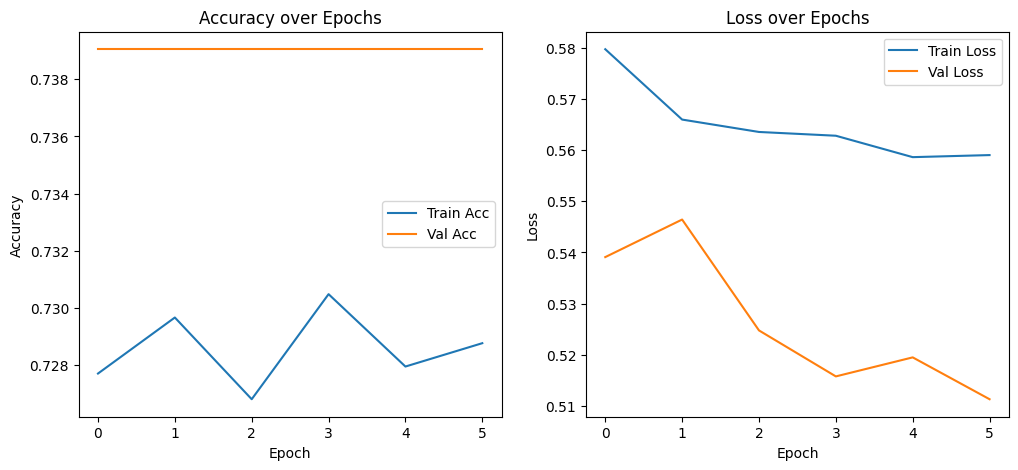

In [16]:
# Define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

# Train with callbacks
history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print("Best model saved at:", MODEL_PATH)

# --- Plot training history ---
import matplotlib.pyplot as plt

acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.title("Loss over Epochs")

plt.show()


## 7. Fine-tuning

## Training with Callbacks (EarlyStopping + ModelCheckpoint)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7245 - loss: 0.5658
Epoch 1: val_accuracy improved from -inf to 0.73906, saving model to C:\\CAS AML\\project M1 and M2\\Chest X Rays v4\pneumonia_xray_EfficientNetB0.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 812s 2s/step - accuracy: 0.7245 - loss: 0.5658 - val_accuracy: 0.7391 - val_loss: 0.5317
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7248 - loss: 0.5605
Epoch 2: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 813s 2s/step - accuracy: 0.7248 - loss: 0.5605 - val_accuracy: 0.7391 - val_loss: 0.5492
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7264 - loss: 0.5640
Epoch 3: val_accuracy did not improve from 0.73906
383/383 ━━━━━━━━━━━━━━━━━━━━ 858s 2s/step - accuracy: 0.7264 - loss: 0.5640 - val_accuracy: 0.7391 - val_loss: 0.5338
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7225 - loss: 0.5653
Epoch 4: val_accuracy did not improve from 0.73906


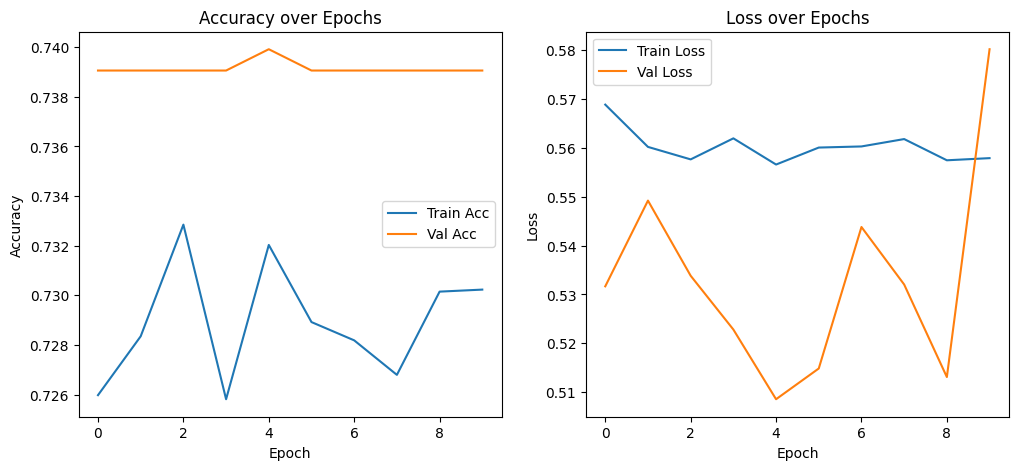

In [17]:
# Define callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    MODEL_PATH, save_best_only=True, monitor="val_accuracy", mode="max", verbose=1
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1
)

# Train with callbacks
history = model.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=30,
    callbacks=[checkpoint_cb, earlystop_cb]
)

print("Best model saved at:", MODEL_PATH)

# --- Plot training history ---
import matplotlib.pyplot as plt

acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(acc, label="Train Acc")
plt.plot(val_acc, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.title("Accuracy over Epochs")

plt.subplot(1,2,2)
plt.plot(loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.title("Loss over Epochs")

plt.show()


## 8. Evaluation

In [18]:
test_results = model.evaluate(test_ds_prep, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, test_results)))

y_true, y_prob = [], []
for images, labels in test_ds_prep:
    probs = model.predict(images, verbose=0)
    y_prob.extend(probs); y_true.extend(labels.numpy())
y_true = np.array(y_true); y_prob = np.array(y_prob)
y_pred = y_prob.argmax(axis=1)

print("Confusion Matrix:\n", confusion_matrix(y_true,y_pred))
print(classification_report(y_true,y_pred, target_names=class_names, digits=4))

pos_label = 1 if "pneumonia" in class_names[1].lower() else 0
auc = roc_auc_score((y_true==pos_label).astype(int), y_prob[:,pos_label])
print("ROC-AUC:", auc)


Test metrics: {'loss': 0.5461252927780151, 'compile_metrics': 0.7096219658851624}
Confusion Matrix:
 [[  2 169]
 [  0 411]]
              precision    recall  f1-score   support

      NORMAL     1.0000    0.0117    0.0231       171
   PNEUMONIA     0.7086    1.0000    0.8295       411

    accuracy                         0.7096       582
   macro avg     0.8543    0.5058    0.4263       582
weighted avg     0.7942    0.7096    0.5925       582

ROC-AUC: 0.8590942075383107


## 9. Sample Predictions

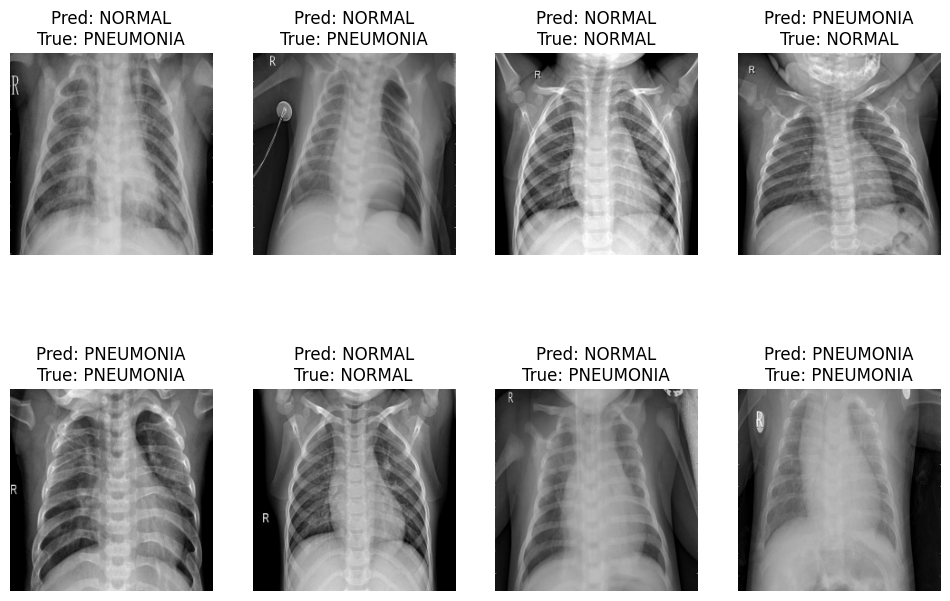

In [19]:
for images, labels in test_ds.take(1):
    probs = model.predict(images, verbose=0)
    preds = probs.argmax(axis=1)
    plt.figure(figsize=(12,8))
    for i in range(min(8, images.shape[0])):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        p, t = class_names[preds[i]], class_names[labels[i].numpy()]
        plt.title(f"Pred: {p}\nTrue: {t}"); plt.axis("off")
    plt.show()
